In [88]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.preprocessing import StandardScaler

In [89]:
# import the US-based youtube dataset
df = pd.read_csv('USvideos.csv')

df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [90]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [91]:
df.dtypes

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

In [92]:
columns_to_drop = ['video_id', 'trending_date', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'comment_count']
df.drop(columns_to_drop, inplace=True, axis=1)

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John..."
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...


## Create our target variable (popularity)
Let's take a look at the distribution of the columns that will be used to calculate engagement score.


In [93]:
# summary stats on `views` `likes` `dislikes` and their scaled versions
print("Summary Stats on Views")
print(df['views'].describe())
print("\nSummary Stats on Likes")
print(df['likes'].describe())
print("\nSummary Stats on Dislikes")
print(df['dislikes'].describe())

Summary Stats on Views
count    4.094900e+04
mean     2.360785e+06
std      7.394114e+06
min      5.490000e+02
25%      2.423290e+05
50%      6.818610e+05
75%      1.823157e+06
max      2.252119e+08
Name: views, dtype: float64

Summary Stats on Likes
count    4.094900e+04
mean     7.426670e+04
std      2.288853e+05
min      0.000000e+00
25%      5.424000e+03
50%      1.809100e+04
75%      5.541700e+04
max      5.613827e+06
Name: likes, dtype: float64

Summary Stats on Dislikes
count    4.094900e+04
mean     3.711401e+03
std      2.902971e+04
min      0.000000e+00
25%      2.020000e+02
50%      6.310000e+02
75%      1.938000e+03
max      1.674420e+06
Name: dislikes, dtype: float64


I kind of hate the plot below-- not sure if we should keep it or update to something else

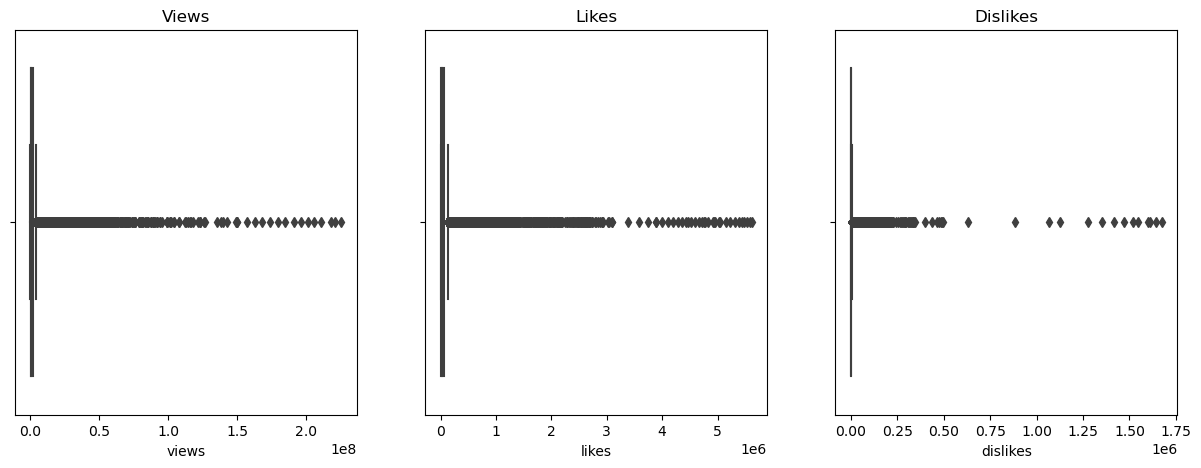

In [94]:
# create boxplots for `views` `likes` `dislikes`
figure, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax=axes[0], data=df, x='views')
axes[0].set_title('Views')
sns.boxplot(ax=axes[1], data=df, x='likes')
axes[1].set_title('Likes')
sns.boxplot(ax=axes[2], data=df, x='dislikes')
axes[2].set_title('Dislikes')
plt.show()

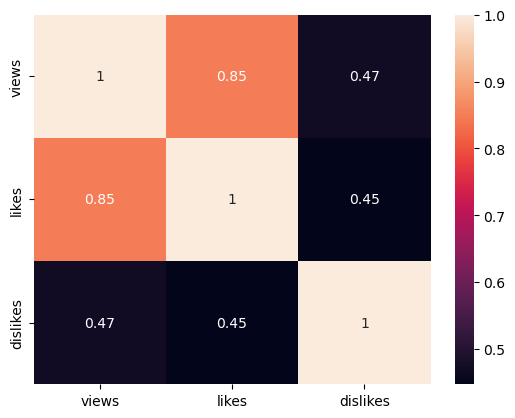

In [95]:
# create heat map of correlations between `views` `likes` `dislikes`
corr = df[['views', 'likes', 'dislikes']].corr()
sns.heatmap(corr, annot=True)
plt.show()


We will scale our `views`, `likes` and `dislikes` columns before we create our engagement score to see if they are a better choice. We will use StandardScaling() as it is less sensitive to outliers. We will look at the distribution of engagement scores to see if we need to transform it.

In [96]:
# scale the views, likes, dislikes

# initialize the scaler
scaler = StandardScaler()

# define columns to be standardized
columns_to_scale = ['views', 'likes', 'dislikes']
scaled_column_names = ['views_scaled', 'likes_scaled', 'dislikes_scaled']

# fit the scaler
df[scaled_column_names] = scaler.fit_transform(df[columns_to_scale])

# check the scaled data
df.head()


,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,views_scaled,likes_scaled,dislikes_scaled
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.218069,-0.073137,-0.025677
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",0.007844,0.100131,0.083867
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.112341,0.313551,0.056067
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,-0.272871,-0.280033,-0.104908
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,-0.035847,0.253267,-0.059333


In [97]:
# create an engagement score column based on the views, likes, dislikes
# the sum of `likes` and `dislikes` divided by the `view` count

df['engagement_score_scaled'] = (df['likes_scaled'] + df['dislikes_scaled']) / df['views_scaled']
df['engagement_score'] = (df['likes'] + df['dislikes']) / df['views']

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,views_scaled,likes_scaled,dislikes_scaled,engagement_score_scaled,engagement_score
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.218069,-0.073137,-0.025677,0.453132,0.080833
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",0.007844,0.100131,0.083867,23.457319,0.042720
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.112341,0.313551,0.056067,3.290155,0.047431
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,-0.272871,-0.280033,-0.104908,1.410705,0.031582
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,-0.035847,0.253267,-0.059333,-5.410032,0.064046


In [98]:
# get stats for engagement score
print('Engagement Score Stats')
print(df['engagement_score'].describe())
print('Engagement Score Scaled Stats')
print(df['engagement_score_scaled'].describe())

Engagement Score Stats
count    40949.000000
mean         0.036027
std          0.027145
min          0.000000
25%          0.016705
50%          0.030038
75%          0.048454
max          0.294794
Name: engagement_score, dtype: float64
Engagement Score Scaled Stats
count     40949.000000
mean          9.956235
std        1753.889100
min       -8692.079336
25%           1.199363
50%           1.419415
75%           1.607763
max      354741.003924
Name: engagement_score_scaled, dtype: float64


It appears that the engagement score of the unscaled data is heavily skewed. We will use the unscaled engagement score for our analysis as it is more interpretable.

/tmp/ipykernel_4835/2770168582.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'], kde=False)


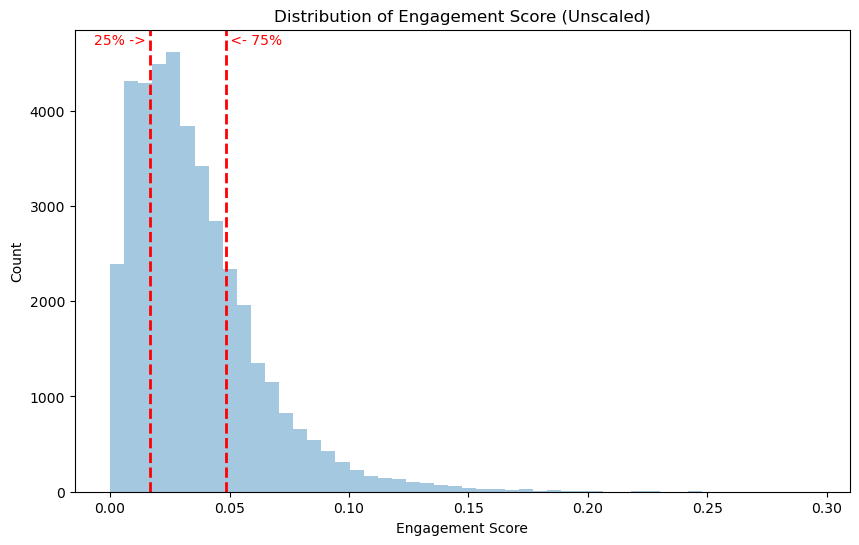

In [99]:
# plot the distribution of the engagement score for both scaled and unscaled data

# plot the unscaled data
plt.figure(figsize=(10, 6))
sns.distplot(df['engagement_score'], kde=False)
plt.title('Distribution of Engagement Score (Unscaled)')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
# add line at interquartile range
plt.axvline(df['engagement_score'].describe()['25%'], color='red', linestyle='dashed', linewidth=2)
plt.axvline(df['engagement_score'].describe()['75%'], color='red', linestyle='dashed', linewidth=2)
# add text to indicate interquartile range
plt.text(df['engagement_score'].describe()['25%'], 4700, '25% -> ', color='red', ha='right')
plt.text(df['engagement_score'].describe()['75%'], 4700, ' <- 75%', color='red', ha='left')
plt.show()

We will use the 75% interquartile range as the threshold to deem something popular or not.

In [100]:
popularity_threshold = df['engagement_score'].describe()['75%']
print('Popularity Threshold:', popularity_threshold)

Popularity Threshold: 0.04845439194090305


Create binary `popular` column based on the threshold (0 = not popular, 1 = popular)

In [101]:
# is popular 0 or 1
df['is_popular'] = df['engagement_score'].apply(lambda x: 1 if x >= popularity_threshold else 0)

df.head()

,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,description,views_scaled,likes_scaled,dislikes_scaled,engagement_score_scaled,engagement_score,is_popular
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,SHANTELL'S CHANNEL - https://www.youtube.com/s...,-0.218069,-0.073137,-0.025677,0.453132,0.080833,1
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,"One year after the presidential election, John...",0.007844,0.100131,0.083867,23.457319,0.042720,0
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0.112341,0.313551,0.056067,3.290155,0.047431,0
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,Today we find out if Link is a Nickelback amat...,-0.272871,-0.280033,-0.104908,1.410705,0.031582,0
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,I know it's been a while since we did this sho...,-0.035847,0.253267,-0.059333,-5.410032,0.064046,1


In [102]:
# remove the columns that are no longer needed
columns_to_drop = ['views', 'likes', 'dislikes', 'views_scaled', 'likes_scaled', 'dislikes_scaled', 'engagement_score', 'engagement_score_scaled']

df.drop(columns_to_drop, inplace=True, axis=1)

df.head()

,title,channel_title,category_id,publish_time,tags,description,is_popular
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/s...,1
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...","One year after the presidential election, John...",0
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,0
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",Today we find out if Link is a Nickelback amat...,0
4,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",I know it's been a while since we did this sho...,1


We will cleanup the text based columns like `title`, `description`, and `tags` by converting it to lowercase, removing punctuation, stop words, and lemmatizing the words.

In [103]:
df['title']

0                       WE WANT TO TALK ABOUT OUR MARRIAGE
1        The Trump Presidency: Last Week Tonight with J...
2        Racist Superman | Rudy Mancuso, King Bach & Le...
3                         Nickelback Lyrics: Real or Fake?
4                                 I Dare You: GOING BALD!?
                               ...                        
40944                         The Cat Who Caught the Laser
40945                           True Facts : Ant Mutualism
40946    I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...
40947                  How Black Panther Should Have Ended
40948    Official Call of Duty®: Black Ops 4 — Multipla...
Name: title, Length: 40949, dtype: object

In [104]:
df['description']

0        SHANTELL'S CHANNEL - https://www.youtube.com/s...
1        One year after the presidential election, John...
2        WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3        Today we find out if Link is a Nickelback amat...
4        I know it's been a while since we did this sho...
                               ...                        
40944       The Cat Who Caught the Laser - Aaron's Animals
40945                                                  NaN
40946    I had so much fun transforming Safiyas hair in...
40947    How Black Panther Should Have EndedWatch More ...
40948    Call of Duty: Black Ops 4 Multiplayer raises t...
Name: description, Length: 40949, dtype: object

In [105]:
df['tags']
# we need to change the | into a space

0                                          SHANtell martin
1        last week tonight trump presidency|"last week ...
2        racist superman|"rudy"|"mancuso"|"king"|"bach"...
3        rhett and link|"gmm"|"good mythical morning"|"...
4        ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
                               ...                        
40944    aarons animals|"aarons"|"animals"|"cat"|"cats"...
40945                                               [none]
40946    I gave safiya nygaard a perfect hair makeover ...
40947    Black Panther|"HISHE"|"Marvel"|"Infinity War"|...
40948        call of duty|"cod"|"activision"|"Black Ops 4"
Name: tags, Length: 40949, dtype: object

In [106]:
import nltk
# only need to do once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/sfirestone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sfirestone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/sfirestone/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [107]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download the stopwords corpus (only required for the first time)
nltk.download('stopwords')

#nltk.data.path.append(nltk.data.path[0])
#nltk.data.path.append('/home/sfirestone/nltk_data')

# Get the set of stopwords
stopwords_set = set(stopwords.words('english'))

# Create a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        # Replace | with space
        text = text.replace('|', ' ')
        # Remove punctuation and special characters
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        text = text.lower()
        # Remove stop words
        text = ' '.join(word for word in text.split() if word not in stopwords_set)
    else:
        text = ''
    return text

# Function to perform lemmatization on text
def lemmatize_text(text):
    if isinstance(text, str):
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Lemmatize each token
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        # Remove stopwords
        lemmatized_text = ' '.join(token for token in lemmatized_tokens if token not in stopwords_set)
    else:
        lemmatized_text = ''
    return lemmatized_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sfirestone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
# Clean the text in the 'title' column
df['title'] = df['title'].apply(clean_text)

df['title']


0                                       want talk marriage
1        trump presidency last week tonight john oliver...
2         racist superman rudy mancuso king bach lele pons
3                              nickelback lyrics real fake
4                                          dare going bald
                               ...                        
40944                                     cat caught laser
40945                             true facts ant mutualism
40946    gave safiya nygaard perfect hair makeover base...
40947                                  black panther ended
40948    official call duty® black ops 4 — multiplayer ...
Name: title, Length: 40949, dtype: object

In [109]:
# Clean the text in the 'description' column
df['description'] = df['description'].apply(clean_text)

df['description']

0        shantells channel httpswwwyoutubecomshantellma...
1        one year presidential election john oliver dis...
2        watch previous video ▶ nnsubscribe ► httpswwwy...
3        today find link nickelback amateur secret nick...
4        know since show back might best episode yetnle...
                               ...                        
40944                      cat caught laser aarons animals
40945                                                     
40946    much fun transforming safiyas hair video servi...
40947    black panther endedwatch hishes httpsbitlyhish...
40948    call duty black ops 4 multiplayer raises bar f...
Name: description, Length: 40949, dtype: object

In [110]:
# Clean the text in the 'tags' column
df['tags'] = df['tags'].apply(clean_text)

df['tags']

0                                          shantell martin
1        last week tonight trump presidency last week t...
2        racist superman rudy mancuso king bach racist ...
3        rhett link gmm good mythical morning rhett lin...
4        ryan higa higatv nigahiga dare idy rhpc dares ...
                               ...                        
40944    aarons animals aarons animals cat cats kitten ...
40945                                                 none
40946    gave safiya nygaard perfect hair makeover base...
40947    black panther hishe marvel infinity war ended ...
40948                 call duty cod activision black ops 4
Name: tags, Length: 40949, dtype: object

In [111]:
# Apply lemmatization to the 'title' column
df['title'] = df['title'].apply(lemmatize_text)

df['title']

0                                       want talk marriage
1        trump presidency last week tonight john oliver...
2         racist superman rudy mancuso king bach lele pons
3                               nickelback lyric real fake
4                                          dare going bald
                               ...                        
40944                                     cat caught laser
40945                              true fact ant mutualism
40946    gave safiya nygaard perfect hair makeover base...
40947                                  black panther ended
40948    official call duty® black ops 4 — multiplayer ...
Name: title, Length: 40949, dtype: object

In [112]:
# Apply lemmatization to the 'description' column
df['description'] = df['description'].apply(lemmatize_text)

df['description']

0        shantells channel httpswwwyoutubecomshantellma...
1        one year presidential election john oliver dis...
2        watch previous video ▶ nnsubscribe ► httpswwwy...
3        today find link nickelback amateur secret nick...
4        know since show back might best episode yetnle...
                               ...                        
40944                        cat caught laser aaron animal
40945                                                     
40946    much fun transforming safiyas hair video servi...
40947    black panther endedwatch hishes httpsbitlyhish...
40948    call duty black ops 4 multiplayer raise bar fa...
Name: description, Length: 40949, dtype: object

In [113]:
# Apply lemmatization to the 'tags' column
df['tags'] = df['tags'].apply(lemmatize_text)

df['tags']

0                                          shantell martin
1        last week tonight trump presidency last week t...
2        racist superman rudy mancuso king bach racist ...
3        rhett link gmm good mythical morning rhett lin...
4        ryan higa higatv nigahiga dare idy rhpc dare t...
                               ...                        
40944    aaron animal aaron animal cat cat kitten kitte...
40945                                                 none
40946    gave safiya nygaard perfect hair makeover base...
40947    black panther hishe marvel infinity war ended ...
40948                 call duty cod activision black ops 4
Name: tags, Length: 40949, dtype: object

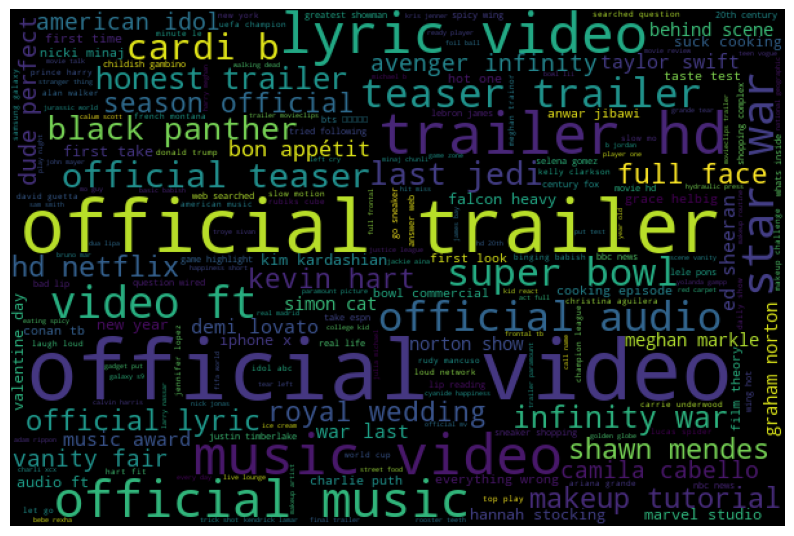

In [114]:
from wordcloud import WordCloud

# Create a word cloud for the 'title' column
title_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['title']))

# Display the generated wordcloud image
plt.figure(figsize=(10, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

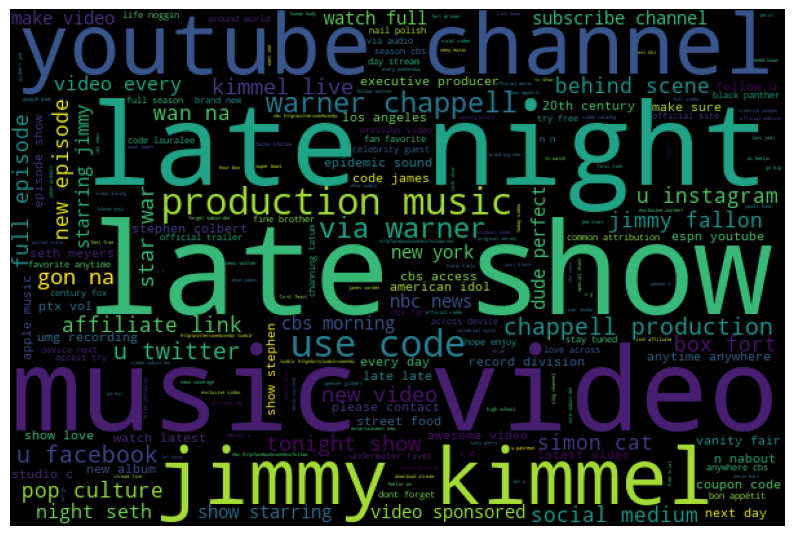

In [115]:
# Create a word cloud for the 'description' column
description_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['description']))

# Display the generated wordcloud image
plt.figure(figsize=(10, 8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

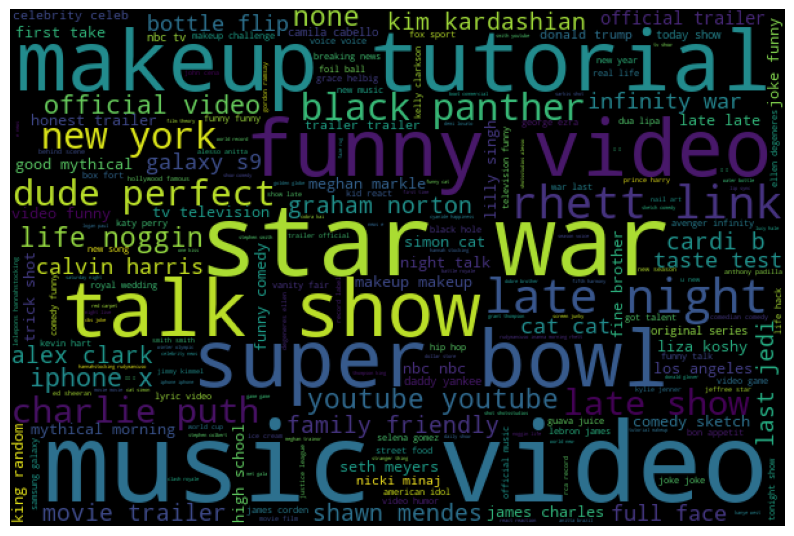

In [116]:
# Create a word cloud for the 'tags' column
tags_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df['tags']))

# Display the generated wordcloud image
plt.figure(figsize=(10, 8))
plt.imshow(tags_wordcloud)
plt.axis('off')
plt.show()

In [117]:
# Break `publish_time` into `month`, `day_of_week`, and `hour` columns

# change publish_time to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'])

# create month column
df['month'] = df['publish_time'].dt.month

# create day of week column
df['day_of_week'] = df['publish_time'].dt.dayofweek

# create hour column
df['hour'] = df['publish_time'].dt.hour

df.head()

,title,channel_title,category_id,publish_time,tags,description,is_popular,month,day_of_week,hour
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,shantells channel httpswwwyoutubecomshantellma...,1,11,0,17
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,one year presidential election john oliver dis...,0,11,0,7
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,watch previous video ▶ nnsubscribe ► httpswwwy...,0,11,6,19
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,today find link nickelback amateur secret nick...,0,11,0,11
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,know since show back might best episode yetnle...,1,11,6,18


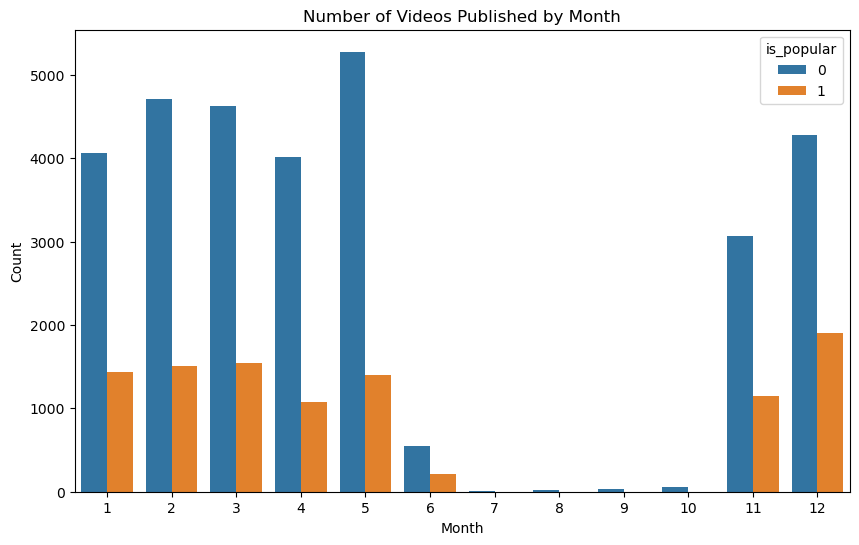

In [118]:
# countplot of videos published by month by popularity
plt.figure(figsize=(10, 6))
sns.countplot(x='month', hue='is_popular', data=df)
plt.title('Number of Videos Published by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

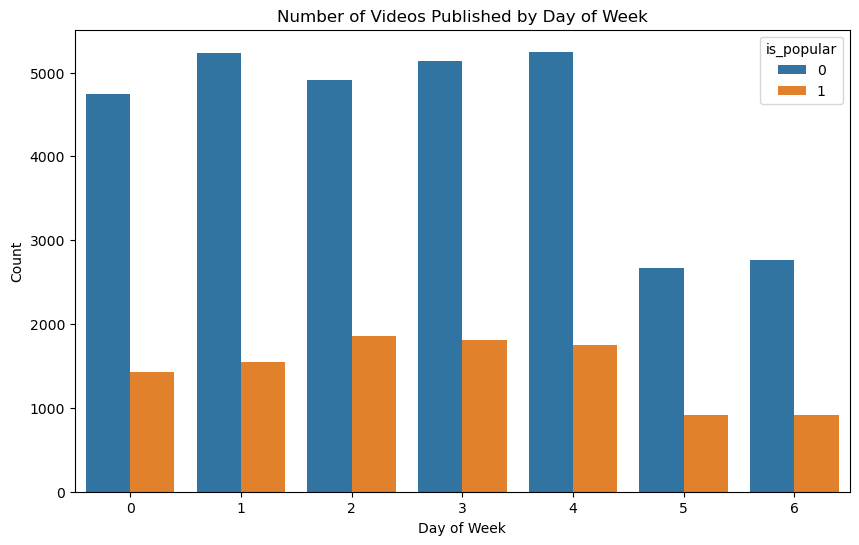

In [119]:
# countplot of videos published by day of week by popularity
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', hue='is_popular', data=df)
plt.title('Number of Videos Published by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

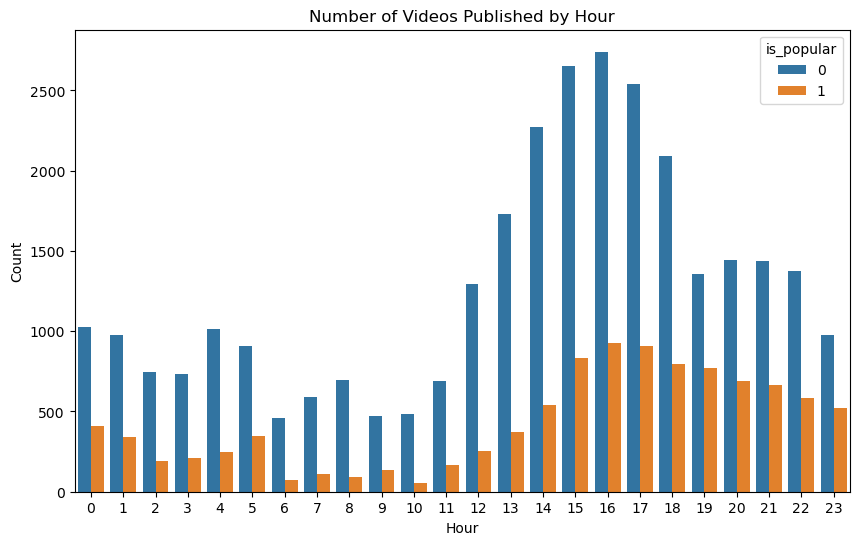

In [120]:
# countplot of videos published by hour by popularity
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', hue='is_popular', data=df)
plt.title('Number of Videos Published by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

The json file has the information saying what categories these numbers refer to. VVV

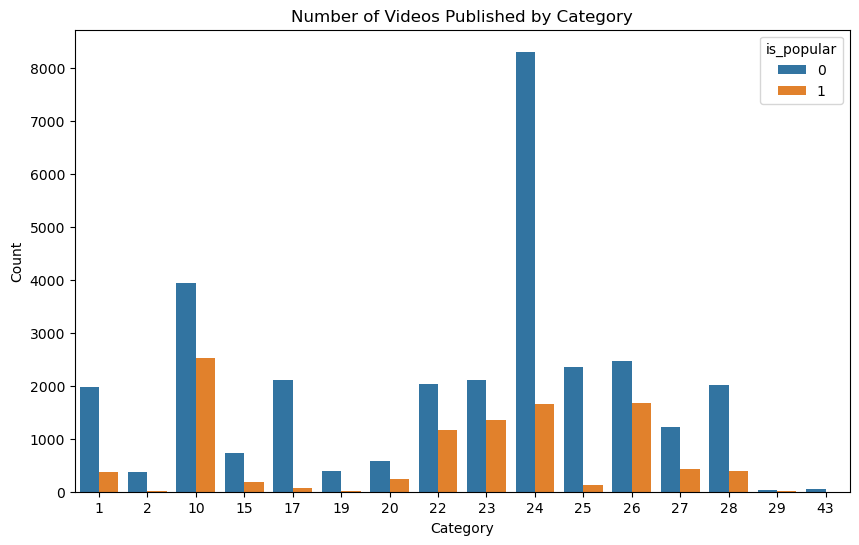

In [121]:
# countplot of videos published by category_id by popularity
plt.figure(figsize=(10, 6))
sns.countplot(x='category_id', hue='is_popular', data=df)
plt.title('Number of Videos Published by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# BELOW I AM TRYING TO FEATURE ENGINEER THE TEXT COLUMNS BUT I HAVE NO IDEA WHAT IM DOING

We must do some feature engineering on the text based columns to make them usable for our model. We will use the `title`, `description`, and `tags` columns to feature engineer new columns like `title_length`, `description_length`, `tag_count`, `tag_length`, and `tag_popularity`.

In [122]:
# Create a new column `title_length` with the length of each video's title
df['title_length'] = df['title'].apply(lambda x: len(x))

# Create a new column `description_length` with the length of each video's description
df['description_length'] = df['description'].apply(lambda x: len(x))

# Create a new column `tags_length` with the length of each video's tags
df['tags_length'] = df['tags'].apply(lambda x: len(x))

df.head()

,title,channel_title,category_id,publish_time,tags,description,is_popular,month,day_of_week,hour,title_length,description_length,tags_length
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,shantells channel httpswwwyoutubecomshantellma...,1,11,0,17,18,1060,15
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,one year presidential election john oliver dis...,0,11,0,7,50,457,96
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,watch previous video ▶ nnsubscribe ► httpswwwy...,0,11,6,19,48,894,261
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,today find link nickelback amateur secret nick...,0,11,0,11,26,1110,399
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,know since show back might best episode yetnle...,1,11,6,18,15,464,83


In [123]:
# create new `text` column with combined text from `title`, `description`, and `tags`

df['text'] = df['title'] + ' ' + df['description'] + ' ' + df['tags']

df.head()

,title,channel_title,category_id,publish_time,tags,description,is_popular,month,day_of_week,hour,title_length,description_length,tags_length,text
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,shantells channel httpswwwyoutubecomshantellma...,1,11,0,17,18,1060,15,want talk marriage shantells channel httpswwwy...
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,one year presidential election john oliver dis...,0,11,0,7,50,457,96,trump presidency last week tonight john oliver...
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,watch previous video ▶ nnsubscribe ► httpswwwy...,0,11,6,19,48,894,261,racist superman rudy mancuso king bach lele po...
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,today find link nickelback amateur secret nick...,0,11,0,11,26,1110,399,nickelback lyric real fake today find link nic...
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,know since show back might best episode yetnle...,1,11,6,18,15,464,83,dare going bald know since show back might bes...


Making generator to create a list of the top 1000 words in the `text` column.

In [124]:
from collections import Counter

top_word_count = 100 # adjust to figure out what is a reasonable number of words analyze

combined_text = ' '.join(df[df['is_popular'] == 1]['text'])  # maybe we only look at the words if the video is "popular"

# split text into individual words
words = combined_text.split()

# create a counter of the words
words_counter = Counter(words)

# generator function that will yield the top 100 words based on their counts
def top_words_generator(word_counts):
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    for word, count in sorted_words[:top_word_count]:
        yield word

# create generator object using the generator function
top_words_gen = top_words_generator(words_counter)

# iterate through the generator to get the top 1000 words
top_words = [word for word in top_words_gen]

top_words[:10]


['video', '’', 'makeup', 'music', 'new', '»', 'get', 'channel', 'make', 'love']

Looks like we are still getting special characters we need to figure out how to remove. ^^^^^

In [125]:
word_counts_df = pd.DataFrame(0, index= df.index, columns=top_words)

#iterate over the rows of the dataframe and count the occurrences of the top words
for i, row in df.iterrows():
    text = row['text']
    words = text.split()
    word_counts = Counter(words)
    for word, count in word_counts.items():
        if word in top_words:
            word_counts_df.loc[i, word] = count

word_counts_df.head()

,video,’,makeup,music,new,»,get,channel,make,love,...,guy,play,much,x,back,friend,fashion,c,star,thank
0,2,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [126]:
col_to_drop = ['title', 'description', 'tags', 'publish_time', 'text', 'channel_title']

df.drop(col_to_drop, axis=1, inplace=True)

df.head()

,category_id,is_popular,month,day_of_week,hour,title_length,description_length,tags_length
0,22,1,11,0,17,18,1060,15
1,24,0,11,0,7,50,457,96
2,23,0,11,6,19,48,894,261
3,24,0,11,0,11,26,1110,399
4,24,1,11,6,18,15,464,83


In [127]:
df = pd.concat([df, word_counts_df], axis=1)

df.head()

,category_id,is_popular,month,day_of_week,hour,title_length,description_length,tags_length,video,’,...,guy,play,much,x,back,friend,fashion,c,star,thank
0,22,1,11,0,17,18,1060,15,2,0,...,0,0,0,0,0,0,0,0,0,0
1,24,0,11,0,7,50,457,96,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23,0,11,6,19,48,894,261,2,0,...,0,0,0,1,0,0,0,0,0,0
3,24,0,11,0,11,26,1110,399,1,1,...,0,0,0,0,0,0,0,0,0,0
4,24,1,11,6,18,15,464,83,0,0,...,0,0,0,0,1,0,0,0,0,0


Me just playing with the model... we need to clean up the text columns more maybe ?

In [128]:
# logisitic regression model
# split data into train and test sets

from sklearn.model_selection import train_test_split

X = df.drop('is_popular', axis=1)
y = df['is_popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32759, 107), (8190, 107), (32759,), (8190,))

In [129]:
# instantiate logistic regression model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

# fit model to training data
lr.fit(X_train, y_train)

# make predictions on test data
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# evaluate model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# on both training and testing sets
print('Training set scores:')
print('Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Precision: ', precision_score(y_train, y_train_pred))
print('Recall: ', recall_score(y_train, y_train_pred))
print('Confusion Matrix: \n', confusion_matrix(y_train, y_train_pred))
print('Classification Report: \n', classification_report(y_train, y_train_pred))

print('Testing set scores:')
print('Accuracy: ', accuracy_score(y_test, y_test_pred))
print('Precision: ', precision_score(y_test, y_test_pred))
print('Recall: ', recall_score(y_test, y_test_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_test_pred))
print('Classification Report: \n', classification_report(y_test, y_test_pred))

Training set scores:
Accuracy:  0.7753289172441161
Precision:  0.6408658576582487
Recall:  0.23774181773938435
Confusion Matrix: 
 [[23445  1095]
 [ 6265  1954]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.96      0.86     24540
           1       0.64      0.24      0.35      8219

    accuracy                           0.78     32759
   macro avg       0.71      0.60      0.61     32759
weighted avg       0.75      0.78      0.73     32759

Testing set scores:
Accuracy:  0.7714285714285715
Precision:  0.5948387096774194
Recall:  0.2283308568598316
Confusion Matrix: 
 [[5857  314]
 [1558  461]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.95      0.86      6171
           1       0.59      0.23      0.33      2019

    accuracy                           0.77      8190
   macro avg       0.69      0.59      0.60      8190
weighted avg       0.74      0.77

/home/sfirestone/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I'm not 100% sure what this is doing. VVV

This is something we should maybe do before our logistic regression model?

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the 'title' column
title_vectorized = vectorizer.fit_transform(df['title'])

# Convert the sparse matrix to a dense array
title_vectorized = title_vectorized.toarray()

df = pd.concat([df, pd.DataFrame(title_vectorized)], axis=1)

df.head()

,title,channel_title,category_id,publish_time,tags,description,is_popular,month,day_of_week,hour,...,9703,9704,9705,9706,9707,9708,9709,9710,9711,9712
0,want talk marriage,CaseyNeistat,22,2017-11-13 17:13:01+00:00,shantell martin,shantells channel httpswwwyoutubecomshantellma...,1,11,0,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,trump presidency last week tonight john oliver...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,last week tonight trump presidency last week t...,one year presidential election john oliver dis...,0,11,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,racist superman rudy mancuso king bach lele pons,Rudy Mancuso,23,2017-11-12 19:05:24+00:00,racist superman rudy mancuso king bach racist ...,watch previous video ▶ nnsubscribe ► httpswwwy...,0,11,6,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nickelback lyric real fake,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,rhett link gmm good mythical morning rhett lin...,today find link nickelback amateur secret nick...,0,11,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dare going bald,nigahiga,24,2017-11-12 18:01:41+00:00,ryan higa higatv nigahiga dare idy rhpc dare t...,know since show back might best episode yetnle...,1,11,6,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I crashed trying to run the cell below.

We gotta think of ways to vectorize all the text columns?

In [1]:
'''
# Apply TF-IDF vectorization to the 'description' column
description_vectorized = vectorizer.fit_transform(df['description'])

# Convert the sparse matrix to a dense array
description_vectorized = description_vectorized.toarray()

# Add the resulting vectorized features to the dataframe
df = pd.concat([df, pd.DataFrame(description_vectorized)], axis=1)

df.head()
'''

"\n# Apply TF-IDF vectorization to the 'description' column\ndescription_vectorized = vectorizer.fit_transform(df['description'])\n\n# Convert the sparse matrix to a dense array\ndescription_vectorized = description_vectorized.toarray()\n\n# Add the resulting vectorized features to the dataframe\ndf = pd.concat([df, pd.DataFrame(description_vectorized)], axis=1)\n\ndf.head()\n"